<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/Conf_Dados/20201124_Ex2/introducaoanomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Na lição 1, * Detecção de anomalias: introdução *, aprendemos que as anomalias são outliers nos dados que merecem um exame mais aprofundado. Discutimos métodos básicos de pontuação para identificar valores discrepantes.

Continuaremos nossa discussão procurando outliers em dados unidimensionais (univariados). Usaremos o escore z e o escore z modificado. Examinaremos os pontos fortes e as limitações de ambas as abordagens.

# Resultados de Aprendizagem

Você deve sair deste tutorial em Python com:
1. Uma compreensão da detecção de anomalias como um algoritmo
2. Uma apreciação da importância de escolher um modelo apropriado para os dados pelos quais julgar o que é normal e o que poderia ser uma anomalia.
3. Alguma experiência prática no uso do escore z e escore z modificado na detecção de anomalias

# Importações

In [1]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

Introdução

Na lição 1, * Detecção de anomalias: introdução *, aprendemos que as anomalias são outliers nos dados que merecem um exame mais aprofundado. Discutimos métodos básicos de pontuação para identificar valores discrepantes.

# Seção 1: Visão geral da detecção de anomalias

Nesta lição, usaremos o escore z e o escore z modificado para detectar anomalias nos dados do mundo real. Inicialmente, usaremos um conjunto de dados em que a detecção de anomalias funciona de maneira relativamente suave. Em seguida, como exercício, você trabalhará com um conjunto de dados em que é necessário mais julgamento para aprender sobre alguns dos desafios associados ao escore z e ao escore z modificado.

### O fluxo de trabalho

Como discutimos na palestra, este é o fluxo de trabalho:

    - Faça um modelo para seus dados
    - Escolha um método de pontuação
    - Escolha um ponto de corte acima / abaixo do qual os pontos sejam anomalias
    - Veja essas anomalias e veja se a análise faz sentido

* CUIDADO *: Embora seja altamente recomendável explorar os dados antes de trabalhar com eles, é inadequado usar essa exploração para decidir qual deve ser o ponto de corte para o método de pontuação. Se você fizer isso, tudo o que receberá serão os valores discrepantes que você já escolheu durante sua exploração. As escolhas de modelagem, pontuação e ponto de corte devem ser feitas sem viés.

# Seção 2: Z-Score em ação - participação do aluno em testes padronizados

Vamos começar com um exemplo em que a detecção de anomalias funciona sem problemas. Examinaremos a participação dos alunos em testes padronizados. Especificamente, examinaremos as taxas de participação dos estudantes no SAT nos distritos escolares de Connecticut em 2012. Os dados brutos estão disponíveis aqui:

https://catalog.data.gov/dataset/sat-district-participation-and-performance-2012-2013

Os dados foram limpos para que os valores ausentes fossem removidos, as porcentagens convertidas em decimais e apenas os dados essenciais de 2012 fossem retidos.

O objetivo desta seção é identificar escolas com baixas taxas de participação como um primeiro passo para ajudar essas escolas a melhorar suas taxas de participação.

Carregue os dados como um quadro de dados do pandas e dê uma olhada neles.

In [2]:
ct_test = pd.read_csv('SAT_CT_District_Participation_2012.csv') 
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


Existem 130 escolas. Por conveniência, usaremos o número do índice como etiqueta numérica para cada distrito escolar e usaremos o nome quando apropriado.

Vamos começar assumindo que os dados podem ser modelados com uma distribuição normal (verificaremos isso mais tarde). E usaremos o escore z para identificar anomalias. Como estamos preocupados com baixas taxas de participação, nosso ponto de corte será um número negativo - estamos procurando escolas com taxas de participação abaixo da média. Aqui nós escolhemos $ z = -2 $. Ou seja, qualquer escola com uma pontuação z abaixo de -2 será rotulada como uma anomalia.

Se as taxas de participação são realmente distribuídas normalmente, então 95% dos dados devem estar dentro de dois desvios padrão da média. Em outras palavras, as anomalias para nosso limiar estão na cauda esquerda de 2,5% da distribuição.

Observe que, para conjuntos de dados maiores, valores absolutos maiores de $ z $ (geralmente $ z = 3 $) são frequentemente usados como limite. Como temos um pequeno conjunto de dados, um grande valor de $ z $ pode levar a que nenhum dado seja rotulado como uma anomalia. Além disso, fomos conservadores em nossa escolha de $ z $, porque queremos ajudar o maior número possível de escolas.

Poderíamos simplesmente avançar e calcular o escore z para a taxa de participação, mas é uma boa prática olhar primeiro as estatísticas fundamentais. Vamos calcular a média e o desvio padrão. Como os dados formam toda a população, reportaremos o desvio padrão da população (em oposição ao desvio padrão da amostra)

In [3]:
mean_rate = ct_test['Participation Rate'].mean()

# ddof is the degrees of freedom correction 
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0)

In [4]:
print('Mean participation rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean participation rate is 0.741
Standard deviation is 0.136


Calcule a pontuação z e adicione o resultado ao quadro de dados.

In [5]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0)
ct_test = ct_test.assign(zscore=zscore_rate)
ct_test.head(8)

,District,Participation Rate,zscore
0,Ansonia,0.66,-0.593779
1,Avon,0.90,1.175649
2,Berlin,0.81,0.512113
3,Bethel,0.86,0.880744
4,Bloomfield,0.81,0.512113
5,Bolton,0.85,0.807018
6,Branford,0.77,0.217209
7,Bridgeport,0.58,-1.183589


Agora identifique as anomalias e plote os resultados.

In [6]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

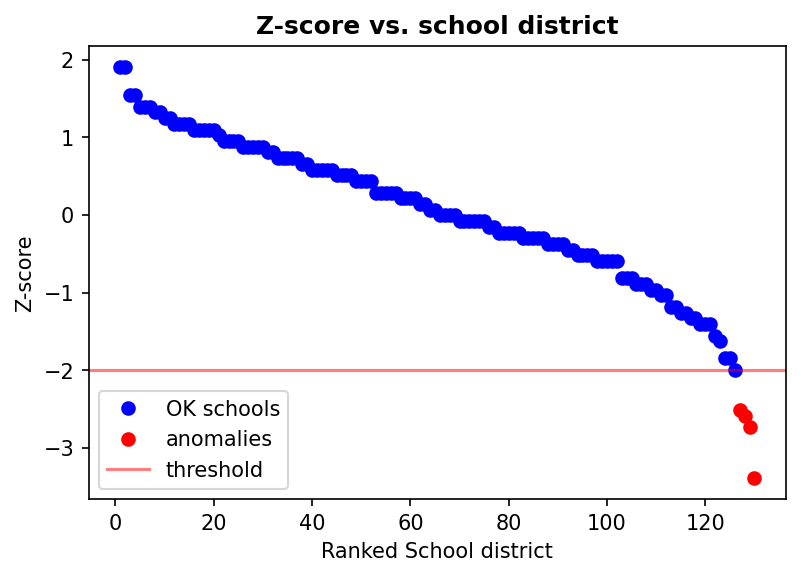

In [7]:
plot_anomaly(ct_test['zscore'], -2)

Por fim, obtenha uma lista das escolas que são anomalias.

In [8]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore
50,New Britain,0.40,-2.510660
99,Windham,0.37,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386
125,Stamford Academy,0.28,-3.395374


Encontramos nossas anomalias, mas ainda temos uma coisa a fazer: verificar nossa suposição de que os dados podem ser modelados aproximadamente como uma distribuição normal. Se for esse o caso, concluímos nosso teste. Caso contrário, não podemos conectar o z-score com probabilidades, como fizemos anteriormente neste caderno.

Primeiro, vamos agrupar os dados e ver como eles são um histograma.

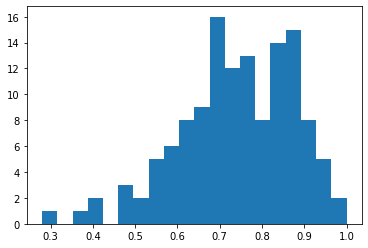

In [9]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Participation Rate'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

Este histograma tem dois máximos e é inclinado para a esquerda, portanto, não é provável que seja normal.

Também podemos comparar a função de distribuição cumulativa de nossos dados com o CDF de uma distribuição normal com a mesma média e desvio padrão de nossos dados.

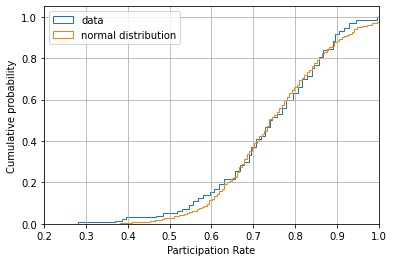

In [10]:
num_bins = 130
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
n, bins, patches = plt.hist(ct_test['Participation Rate'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True)
plt.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0.2,1.0])
plt.xlabel('Participation Rate')
plt.ylabel('Cumulative probability')
plt.show()

Embora nossos dados sejam inconsistentes com uma distribuição normal, o escore z e o escore z modificado nos ajudaram a identificar discrepâncias. Portanto, embora não possamos fazer nenhuma afirmação probabilística com base nos escores z, podemos focar com segurança nossas quatro escolas.

# Seção 3: Escore Z vs. Escore Z modificado - Melhores marcadores da Copa do Mundo

Agora, examinaremos um conjunto de dados que mostra as limitações dos escores z e por que o escore z modificado pode ser útil.

Vamos chegar ao número de gols marcados pelo melhor marcador de todas as Copas do Mundo entre 1930 e 2018 (21 competições no total). Os dados brutos são daqui:

https://en.wikipedia.org/wiki/FIFA_World_Cup_top_goalscorers

Os dados foram limpos e salvos como um CSV. Carregue-o como um quadro de dados e dê uma olhada.

In [11]:
# First row is a header row, but the header names are cumbersome. 
# Skip first row and manually label
# Encoding ensures that accents in sames are rendered properly 
top_goals = pd.read_csv('world_cup_top_goal_scorers.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)                                                                                
top_goals

,Year,Player(s),Goals
0,1930,Guillermo Stábile,8
1,1934,Oldřich Nejedlý,5
2,1938,Leônidas,7
3,1950,Ademir,8
4,1954,Sándor Kocsis,11
5,1958,Just Fontaine,13
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4
7,1966,Eusébio,9
8,1970,Gerd Müller,10
9,1974,Grzegorz Lato,7


Mais uma vez, você começará a usar o z-score para identificar anomalias. Como estamos interessados nas superestrelas, desta vez teremos um limite superior. Escolhemos $ z = + 2 $. Acima deste escore z, qualquer jogador será rotulado como uma anomalia.

Como antes, calculamos a média e o desvio padrão.

In [12]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


Calcule a pontuação z de cada jogador e adicione o resultado ao quadro de dados.

In [13]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

,Year,Player(s),Goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647
8,1970,Gerd Müller,10,1.374051
9,1974,Grzegorz Lato,7,-0.022162


Agora, modifique a função de plotagem anterior para exibir os resultados.

In [14]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

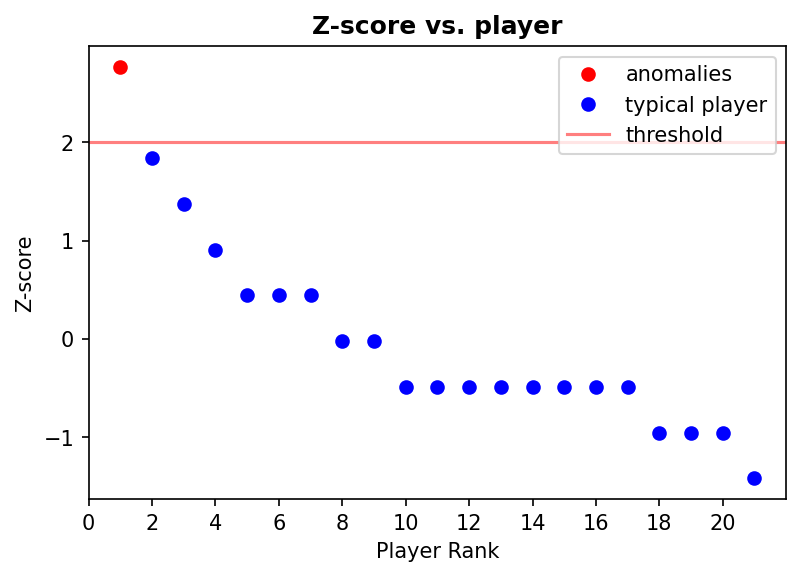

In [15]:
plot_anomaly_goals(top_goals['zscore'], 2)

Apenas um jogador é escolhido: Just Fontaine.

In [16]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


Fontaine era realmente um jogador incrível, mas claramente nossa análise é falha. Olhando para o enredo, vemos que em 12 das 21 competições, o (s) melhor (es) goleador (s) marcou (s) menos do que o número médio de gols (7,05).

** Pergunta **: O que está acontecendo?

** Resposta **: Estamos vendo um efeito discutido em palestras - a média e o desvio padrão são suscetíveis à presença de anomalias. Com seus 13 gols, o incrível Fontaine está aumentando tanto a média que a maioria dos jogadores fica abaixo. Como resultado, ele se torna a única anomalia.

Vamos repetir esta análise com o z-score modificado e ver o que acontece.

In [17]:
median_goals = np.median(top_goals['Goals'])
median_goals

6.0

Observe que a mediana (6,0) é menor que a média (7,05), como seria esperado no gráfico.

Agora calcule o escore z modificado. Lembre-se de que nas palestras isso foi definido para cada ponto de dados $ x_ {i} $ da seguinte maneira:

$y_{i} = (x_{i} - \tilde X)/{\rm MAD}$

onde $ \ til X $ é a mediana dos dados e MAD é a mediana do desvio absoluto da mediana.

Aqui, faremos uma pequena modificação e introduziremos uma correção de consistência $ k $, que nos permitirá usar o MAD como uma estimativa consistente para o desvio padrão. O valor de $ k $ depende da distribuição subjacente dos dados. Por uma questão de simplicidade, usaremos o valor para uma distribuição normal $ k = 1,4826 $ (consulte [https://en.wikipedia.org/wiki/Median_absolute_deviation-16(https://en.wikipedia.org/wiki/Median_absolute_deviation)) .

** Nota: ** O fator de correção de $ k = 1,4826 $ ainda assume que os dados subjacentes são normais!

Portanto, o escore z modificado se torna

$y_{i} = (x_{i} - \tilde X)/(k*{\rm MAD})$

e este é o formulário que usaremos na função abaixo.

In [18]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Returns the modified z score and Median Absolute Deviation (MAD) from the scores in data.
    The consistency_correction factor converts the MAD to the standard deviation for a given
    distribution. The default value (1.4826) is the conversion factor if the underlying data
    is normally distributed
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

Como antes, calcule o escore z modificado para todos os jogadores e depois plote e liste os resultados. Observe que o limite permanece o mesmo em $ y = + 2 $.

In [19]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [20]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

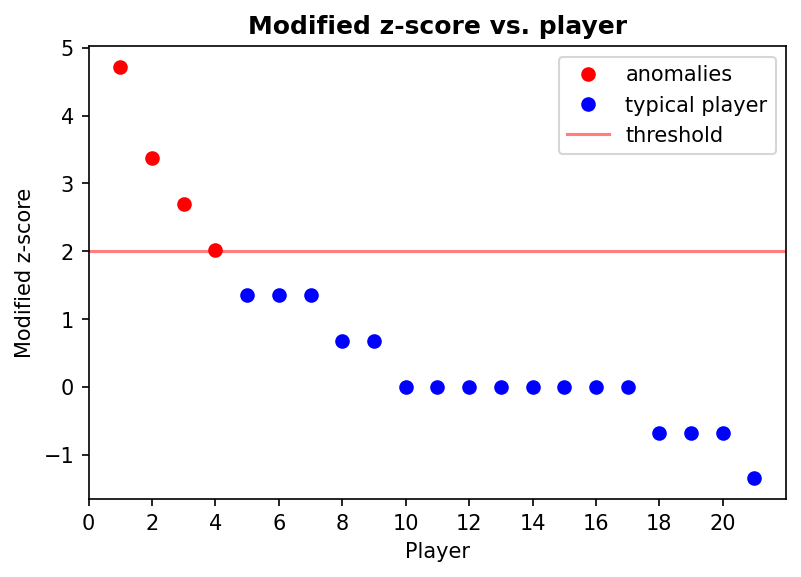

In [21]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [22]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


Agora encontramos quatro jogadores anômalos.

** Pergunta: ** Como o MAD se compara ao desvio padrão calculado anteriormente?

**Answer:** 

In [23]:
print('The value of MAD is {:.2f}'.format(mad_goals))

The value of MAD is 1.00


e $ k * {\ rm MAD} $ é 1,48, que é menor que o desvio padrão (2,05). Vemos que as anomalias têm um efeito maior no desvio padrão, que depende do quadrado do desvio da média (MAD depende linearmente do desvio).

Obviamente, os dados dos melhores marcadores não são normalmente distribuídos, portanto, não podemos associar probabilidades às nossas pontuações, mas nossa análise mostra a necessidade de pensar no método de pontuação usado com os dados.